## Tabla con 100 features para modelamietno

In [9]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

# -----------------------------
# 1. Cargar datasets
# -----------------------------
orders = pd.read_csv("./dataset/olist_orders_dataset.csv", parse_dates=['order_purchase_timestamp','order_delivered_customer_date','order_estimated_delivery_date'])
reviews = pd.read_csv("./dataset/olist_order_reviews_dataset.csv", parse_dates=['review_creation_date','review_answer_timestamp'])
items = pd.read_csv("./dataset/olist_order_items_dataset.csv")
products = pd.read_csv("./dataset/olist_products_dataset.csv")
customers = pd.read_csv("./dataset/olist_customers_dataset.csv")
payments = pd.read_csv("./dataset/olist_order_payments_dataset.csv")

# Merge datasets
df = orders.merge(reviews, on='order_id', how='left')
df = df.merge(items, on='order_id', how='left')
df = df.merge(products, on='product_id', how='left')
df = df.merge(customers, on='customer_id', how='left')
df = df.merge(payments, on='order_id', how='left')

# -----------------------------
# 2. Variable objetivo: satisfacción
# -----------------------------
df['satisfaction'] = df['review_score'].apply(lambda x: 0 if x >= 4 else 1)

# -----------------------------
# 3. Features derivadas por cliente
# -----------------------------
df_customer = df.groupby('customer_id').agg({
    'order_id':'count',           
    'price':'sum',                
    'freight_value':'sum',        
    'product_id':'nunique',       
    'payment_type':'nunique',     
    'review_score':['min','max','mean','std'],  
    'satisfaction':'max',          
    'order_purchase_timestamp':'min',
    'order_delivered_customer_date':'max'
})

# Flatten columnas multi-index
df_customer.columns = [
    'total_orders','total_spent','total_freight','num_products','num_payment_types',
    'min_review','max_review','mean_review','std_review',
    'satisfaction','first_order_date','last_order_date'
]

# -----------------------------
# 4. Features de tiempo
# -----------------------------
today = pd.Timestamp('2025-11-17')
df_customer['days_since_last_order'] = (today - df_customer['last_order_date']).dt.days
df_customer['customer_lifetime'] = (df_customer['last_order_date'] - df_customer['first_order_date']).dt.days
df_customer['avg_days_between_orders'] = df_customer['customer_lifetime'] / df_customer['total_orders']

# -----------------------------
# 5. Features de pago
# -----------------------------
payment_features = df.groupby('customer_id')['payment_type'].value_counts().unstack(fill_value=0)
payment_features.columns = [f'payment_count_{col}' for col in payment_features.columns]
df_customer = df_customer.merge(payment_features, left_index=True, right_index=True, how='left')

# -----------------------------
# 6. Features de entrega
# -----------------------------
df['delivery_delay'] = (df['order_delivered_customer_date'] - df['order_estimated_delivery_date']).dt.days
df_customer['avg_delivery_delay'] = df.groupby('customer_id')['delivery_delay'].mean().fillna(0)
df_customer['late_delivery_count'] = df.groupby('customer_id')['delivery_delay'].apply(lambda x: (x>3).sum())

# -----------------------------
# 7. Features por producto
# -----------------------------
df_customer['avg_price_per_product'] = df_customer['total_spent'] / df_customer['num_products']
df_customer['avg_freight_per_product'] = df_customer['total_freight'] / df_customer['num_products']

# -----------------------------
# 8. Preparar dataset
# -----------------------------
X = df_customer.drop(columns=['satisfaction','first_order_date','last_order_date'])
y = df_customer['satisfaction']
X = X.fillna(0)

# -----------------------------
# 9. Split train/test
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# -----------------------------
# 10. Entrenar XGBoost y obtener importancia
# -----------------------------
xgb = XGBClassifier(n_estimators=300, learning_rate=0.05, max_depth=6, eval_metric='logloss', use_label_encoder=False)
xgb.fit(X_train, y_train)

feat_imp = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb.feature_importances_
}).sort_values(by='importance', ascending=False)

# -----------------------------
# 11. Identificar tipo de variable
# -----------------------------
def var_type(col, df):
    if np.issubdtype(df[col].dtype, np.number):
        return 'numérica'
    elif np.issubdtype(df[col].dtype, np.datetime64):
        return 'temporal'
    else:
        return 'categórica'

feat_imp['type'] = feat_imp['feature'].apply(lambda f: var_type(f, X))

# -----------------------------
# 12. Seleccionar top 100 features
# -----------------------------
top_100_features = feat_imp.head(100).reset_index(drop=True)

# -----------------------------
# 13. Mostrar resultado
# -----------------------------
print(top_100_features)


                      feature  importance      type
0                  min_review         1.0  numérica
1                 total_spent         0.0  numérica
2               total_freight         0.0  numérica
3                num_products         0.0  numérica
4                total_orders         0.0  numérica
5           num_payment_types         0.0  numérica
6                  max_review         0.0  numérica
7                 mean_review         0.0  numérica
8                  std_review         0.0  numérica
9       days_since_last_order         0.0  numérica
10          customer_lifetime         0.0  numérica
11    avg_days_between_orders         0.0  numérica
12       payment_count_boleto         0.0  numérica
13  payment_count_credit_card         0.0  numérica
14   payment_count_debit_card         0.0  numérica
15  payment_count_not_defined         0.0  numérica
16      payment_count_voucher         0.0  numérica
17         avg_delivery_delay         0.0  numérica
18        la

c:\Users\ludwing.young\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:199: UserWarning: [22:10:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [10]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

# -----------------------------
# 1. Cargar datasets
# -----------------------------
orders = pd.read_csv("./dataset/olist_orders_dataset.csv", parse_dates=['order_purchase_timestamp','order_delivered_customer_date','order_estimated_delivery_date'])
reviews = pd.read_csv("./dataset/olist_order_reviews_dataset.csv")
items = pd.read_csv("./dataset/olist_order_items_dataset.csv")
products = pd.read_csv("./dataset/olist_products_dataset.csv")
customers = pd.read_csv("./dataset/olist_customers_dataset.csv")
payments = pd.read_csv("./dataset/olist_order_payments_dataset.csv")

# Merge datasets
df = orders.merge(reviews, on='order_id', how='left')
df = df.merge(items, on='order_id', how='left')
df = df.merge(products, on='product_id', how='left')
df = df.merge(customers, on='customer_id', how='left')
df = df.merge(payments, on='order_id', how='left')

# -----------------------------
# 2. Variable objetivo: satisfacción
# -----------------------------
df['satisfaction'] = df['review_score'].apply(lambda x: 0 if x >= 4 else 1)

# -----------------------------
# 3. Features derivadas por cliente (sin usar review_score directamente)
# -----------------------------
df_customer = df.groupby('customer_id').agg({
    'order_id':'count',           # total compras
    'price':'sum',                # total gastado
    'freight_value':'sum',        # total envío
    'product_id':'nunique',       # productos distintos
    'payment_type':'nunique',     # diversidad de pagos
    'order_purchase_timestamp':'min',
    'order_delivered_customer_date':'max'
}).reset_index()

# Renombrar columnas
df_customer.rename(columns={
    'order_id':'total_orders',
    'price':'total_spent',
    'freight_value':'total_freight',
    'product_id':'num_products',
    'payment_type':'num_payment_types',
    'order_purchase_timestamp':'first_order_date',
    'order_delivered_customer_date':'last_order_date'
}, inplace=True)

# -----------------------------
# 4. Features temporales
# -----------------------------
today = pd.Timestamp('2025-11-17')
df_customer['days_since_last_order'] = (today - df_customer['last_order_date']).dt.days
df_customer['customer_lifetime'] = (df_customer['last_order_date'] - df_customer['first_order_date']).dt.days
df_customer['avg_days_between_orders'] = df_customer['customer_lifetime'] / df_customer['total_orders']

# -----------------------------
# 5. Features de pago
# -----------------------------
payment_features = df.groupby('customer_id')['payment_type'].value_counts().unstack(fill_value=0)
payment_features.columns = [f'payment_count_{col}' for col in payment_features.columns]
df_customer = df_customer.merge(payment_features, left_on='customer_id', right_index=True, how='left')

# -----------------------------
# 6. Features de entrega
# -----------------------------
df['delivery_delay'] = (df['order_delivered_customer_date'] - df['order_estimated_delivery_date']).dt.days
df_customer['avg_delivery_delay'] = df.groupby('customer_id')['delivery_delay'].mean().fillna(0)
df_customer['late_delivery_count'] = df.groupby('customer_id')['delivery_delay'].apply(lambda x: (x>3).sum())

# -----------------------------
# 7. Features por producto
# -----------------------------
df_customer['avg_price_per_product'] = df_customer['total_spent'] / df_customer['num_products']
df_customer['avg_freight_per_product'] = df_customer['total_freight'] / df_customer['num_products']

# -----------------------------
# 8. Preparar dataset
# -----------------------------
X = df_customer.drop(columns=['customer_id','first_order_date','last_order_date'])
y = df['satisfaction'].groupby(df['customer_id']).max()  # agrega satisfacción máxima por cliente
X = X.fillna(0)

# -----------------------------
# 9. Split train/test
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# -----------------------------
# 10. Entrenar XGBoost y obtener importancia
# -----------------------------
xgb = XGBClassifier(n_estimators=300, learning_rate=0.05, max_depth=6, eval_metric='logloss', use_label_encoder=False)
xgb.fit(X_train, y_train)

feat_imp = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb.feature_importances_
}).sort_values(by='importance', ascending=False)

# -----------------------------
# 11. Identificar tipo de variable
# -----------------------------
def var_type(col, df):
    if np.issubdtype(df[col].dtype, np.number):
        return 'numérica'
    elif np.issubdtype(df[col].dtype, np.datetime64):
        return 'temporal'
    else:
        return 'categórica'

feat_imp['type'] = feat_imp['feature'].apply(lambda f: var_type(f, X))

# -----------------------------
# 12. Seleccionar top 100 features
# -----------------------------
top_100_features = feat_imp.head(100).reset_index(drop=True)

# -----------------------------
# 13. Mostrar resultado
# -----------------------------
print(top_100_features)


c:\Users\ludwing.young\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:199: UserWarning: [22:10:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


                      feature  importance      type
0                total_orders    0.243702  numérica
1           customer_lifetime    0.222603  numérica
2                num_products    0.163326  numérica
3       days_since_last_order    0.125716  numérica
4           num_payment_types    0.050317  numérica
5   payment_count_credit_card    0.039584  numérica
6     avg_freight_per_product    0.026678  numérica
7               total_freight    0.023411  numérica
8       avg_price_per_product    0.019214  numérica
9                 total_spent    0.018138  numérica
10    avg_days_between_orders    0.017804  numérica
11       payment_count_boleto    0.017652  numérica
12      payment_count_voucher    0.017253  numérica
13   payment_count_debit_card    0.014601  numérica
14  payment_count_not_defined    0.000000  numérica
15        late_delivery_count    0.000000  numérica
16         avg_delivery_delay    0.000000  numérica


C:\Users\ludwing.young\AppData\Local\Temp\ipykernel_26296\2154951139.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=top_30, palette='viridis')


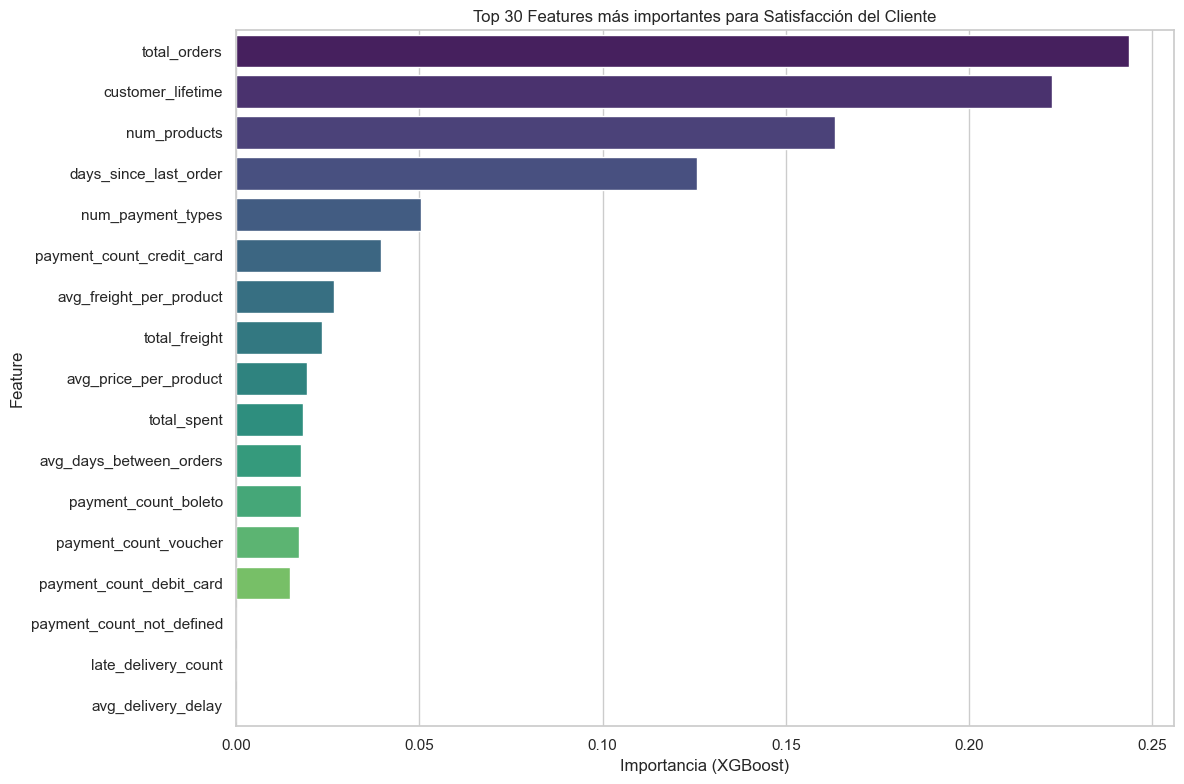

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Seleccionar top 30 features
top_30 = top_100_features.head(30)

plt.figure(figsize=(12,8))
sns.barplot(x='importance', y='feature', data=top_30, palette='viridis')
plt.title("Top 30 Features más importantes para Satisfacción del Cliente")
plt.xlabel("Importancia (XGBoost)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

c:\Users\ludwing.young\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:199: UserWarning: [22:10:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


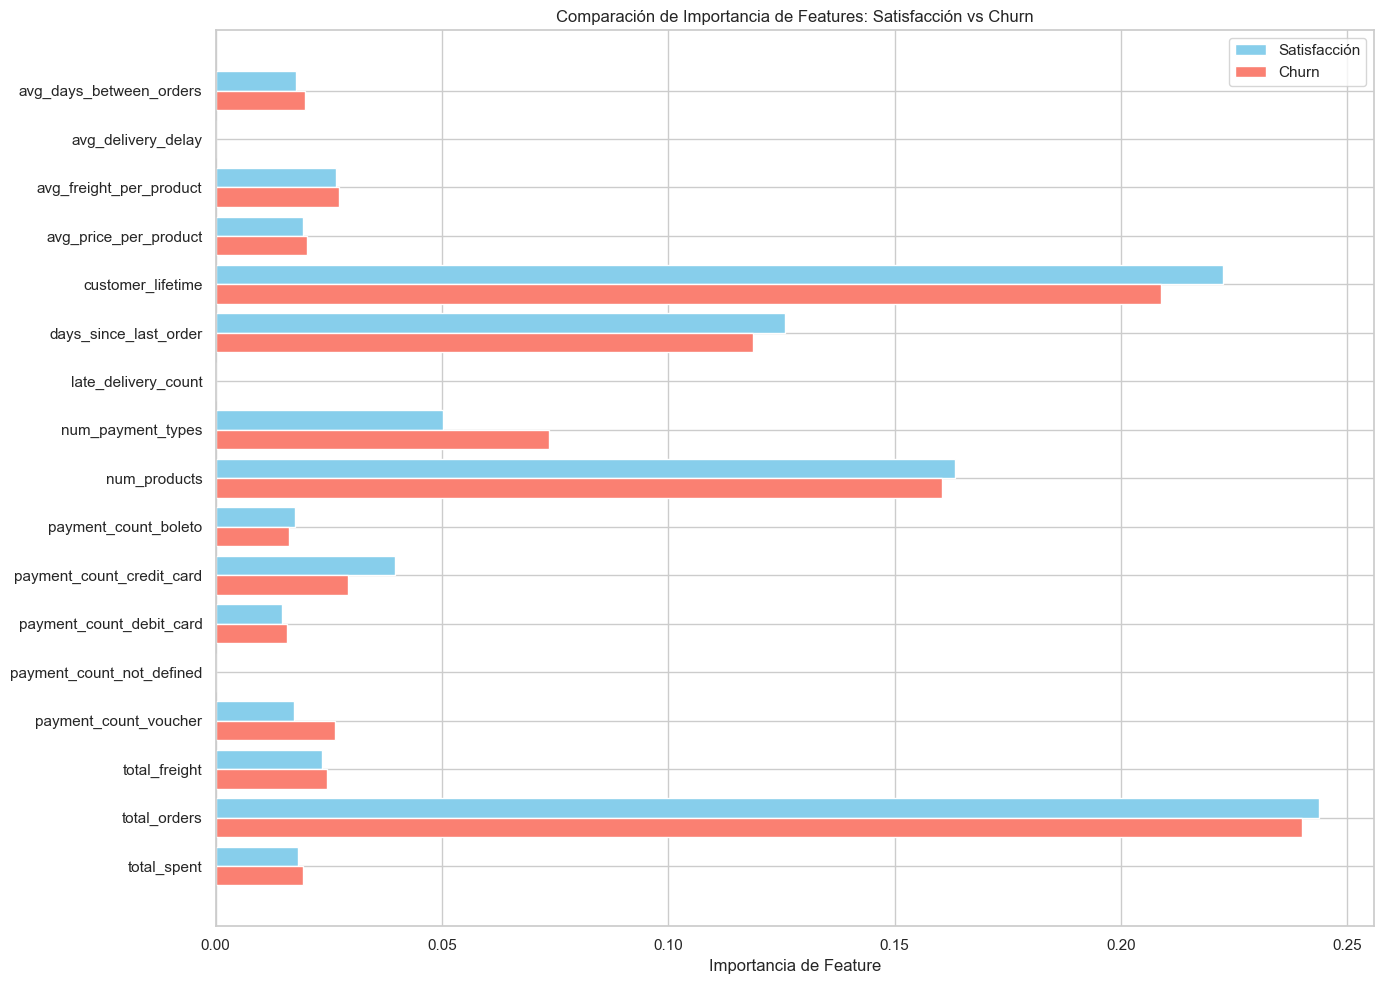

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

# -----------------------------
# Preparar datos para churn
# -----------------------------
# Churn = 1 si alguna compra review_score <=2
df_customer['churn_flag'] = df.groupby('customer_id')['review_score'].apply(lambda x: (x<=2).max()).values

X_churn = X.copy()
y_churn = df_customer['churn_flag']

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_churn, y_churn, test_size=0.2, random_state=42, stratify=y_churn
)

xgb_c = XGBClassifier(n_estimators=300, learning_rate=0.05, max_depth=6, eval_metric='logloss', use_label_encoder=False)
xgb_c.fit(X_train_c, y_train_c)

feat_imp_churn = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_c.feature_importances_
}).sort_values(by='importance', ascending=False)

# -----------------------------
# Combinar importancia de satisfacción y churn
# -----------------------------
top_features = 30
top_satisfaction = top_100_features.head(top_features)[['feature','importance']].rename(columns={'importance':'importance_satisfaction'})
top_churn = feat_imp_churn.head(top_features).rename(columns={'importance':'importance_churn'})

# Merge por feature
merged_imp = pd.merge(top_satisfaction, top_churn, on='feature', how='outer').fillna(0)

# -----------------------------
# Gráfico comparado
# -----------------------------
plt.figure(figsize=(14,10))
bar_width = 0.4
y_pos = np.arange(len(merged_imp))

plt.barh(y_pos - bar_width/2, merged_imp['importance_satisfaction'], height=bar_width, label='Satisfacción', color='skyblue')
plt.barh(y_pos + bar_width/2, merged_imp['importance_churn'], height=bar_width, label='Churn', color='salmon')

plt.yticks(y_pos, merged_imp['feature'])
plt.xlabel("Importancia de Feature")
plt.title("Comparación de Importancia de Features: Satisfacción vs Churn")
plt.legend()
plt.gca().invert_yaxis()  # Mostrar la más importante arriba
plt.tight_layout()
plt.show()


In [13]:
import pandas as pd

# ==============================
# Cargar datasets
# ==============================
orders = pd.read_csv("./dataset/olist_orders_dataset.csv")
reviews = pd.read_csv("./dataset/olist_order_reviews_dataset.csv")
items = pd.read_csv("./dataset/olist_order_items_dataset.csv")
products = pd.read_csv("./dataset/olist_products_dataset.csv")
sellers = pd.read_csv("./dataset/olist_sellers_dataset.csv")

# ==============================
# Integrar en un solo dataframe
# ==============================
df = orders.merge(reviews, on="order_id", how="left")
df = df.merge(items, on="order_id", how="left")
df = df.merge(products, on="product_id", how="left")
df = df.merge(sellers, on="seller_id", how="left")

# ==============================
# Crear variable de insatisfacción
# ==============================
df['is_bad'] = df['review_score'].apply(lambda x: 1 if x <= 3 else 0)

# ==============================
# 1 – Impacto del retraso en entrega
# ==============================
df['delivery_delay'] = (
    pd.to_datetime(df['order_delivered_customer_date']) -
    pd.to_datetime(df['order_estimated_delivery_date'])
).dt.days

delay_summary = df.groupby('is_bad')['delivery_delay'].mean()

# ==============================
# 2 – Peores categorías
# ==============================
category_bad = df.groupby('product_category_name')['is_bad'].mean().sort_values(ascending=False).head(10)

# ==============================
# 3 – Impacto del precio y flete
# ==============================
price_summary = df.groupby('is_bad')['price'].mean()
freight_summary = df.groupby('is_bad')['freight_value'].mean()

# ==============================
# 4 – Vendedores con mayor índice de insatisfacción
# ==============================
seller_bad_full = (
    df.groupby(['seller_city', 'seller_state'])['is_bad']
    .mean()
    .reset_index()
    .sort_values(by='is_bad', ascending=False)
    .head(20)   # puedes cambiar a top 10, top 50, etc.
)


# ==============================
# Mostrar resultados
# ==============================
print("\n=== 1. Retraso promedio por nivel de satisfacción ===")
print(delay_summary)

print("\n=== 2. Top 10 categorías con más insatisfacción ===")
print(category_bad)

print("\n=== 3. Precio promedio según satisfacción ===")
print(price_summary)

print("\n=== 4. Flete promedio según satisfacción ===")
print(freight_summary)

print("\n=== Top sellers con mayor insatisfacción (incluye nombres) ===")
print(seller_bad_full)



=== 1. Retraso promedio por nivel de satisfacción ===
is_bad
0   -13.134122
1    -8.364092
Name: delivery_delay, dtype: float64

=== 2. Top 10 categorías con más insatisfacción ===
product_category_name
fraldas_higiene                                  0.538462
portateis_cozinha_e_preparadores_de_alimentos    0.533333
seguros_e_servicos                               0.500000
moveis_escritorio                                0.399765
artigos_de_festas                                0.348837
fashion_roupa_masculina                          0.333333
pc_gamer                                         0.333333
casa_conforto_2                                  0.333333
casa_conforto                                    0.329519
telefonia_fixa                                   0.324528
Name: is_bad, dtype: float64

=== 3. Precio promedio según satisfacción ===
is_bad
0    120.692023
1    119.814048
Name: price, dtype: float64

=== 4. Flete promedio según satisfacción ===
is_bad
0    19.697304
1    

In [14]:
# ====================================
# 1. Crear variable de insatisfacción
# ====================================
# 1 = insatisfecho (review_score <= 3), 0 = satisfecho
df['is_bad'] = df['review_score'].apply(lambda x: 1 if x <= 3 else 0)

# ====================================
# 2. Calcular insatisfacción por categoría de producto
# ====================================
category_bad = (
    df.groupby('product_category_name')['is_bad']
    .mean()
    .reset_index()
    .sort_values(by='is_bad', ascending=False)
)

print("\n=== Categorías con mayor insatisfacción ===")
print(category_bad.head(20))


=== Categorías con mayor insatisfacción ===
                            product_category_name    is_bad
42                                fraldas_higiene  0.538462
65  portateis_cozinha_e_preparadores_de_alimentos  0.533333
67                             seguros_e_servicos  0.500000
55                              moveis_escritorio  0.399765
5                               artigos_de_festas  0.348837
38                        fashion_roupa_masculina  0.333333
60                                       pc_gamer  0.333333
15                                casa_conforto_2  0.333333
14                                  casa_conforto  0.329519
71                                 telefonia_fixa  0.324528
36                         fashion_roupa_feminina  0.320000
7                                           audio  0.312329
52                      moveis_colchao_e_estofado  0.289474
25               construcao_ferramentas_seguranca  0.288660
57                                    moveis_sala  0.28

In [15]:
import pandas as pd
import numpy as np

# =====================================================
# 1. Cargar los datasets originales
# =====================================================
orders = pd.read_csv("./dataset/olist_orders_dataset.csv")
reviews = pd.read_csv("./dataset/olist_order_reviews_dataset.csv")
items = pd.read_csv("./dataset/olist_order_items_dataset.csv")
products = pd.read_csv("./dataset/olist_products_dataset.csv")
sellers = pd.read_csv("./dataset/olist_sellers_dataset.csv")

# =====================================================
# 2. Merge completo
# =====================================================
df = orders.merge(reviews, on="order_id", how="left")
df = df.merge(items, on="order_id", how="left")
df = df.merge(products, on="product_id", how="left")
df = df.merge(sellers, on="seller_id", how="left")

# =====================================================
# 3. Variables objetivo basadas en review_score
# =====================================================

# Satisfacción (0 = satisfecho, 1 = insatisfecho)
df["satisfaction"] = df["review_score"].apply(lambda x: 0 if x >= 4 else 1)

# Churn (1 = cliente en riesgo)
df["churn_flag"] = df["review_score"].apply(lambda x: 1 if x <= 2 else 0)

# =====================================================
# 4. ANALISIS DE INSATISFACCION POR CATEGORIA (PRODUCTOS)
# =====================================================

# --- A. Review score promedio por categoría
category_mean = (
    df.groupby("product_category_name")["review_score"]
    .mean()
    .reset_index()
    .sort_values(by="review_score")
)

print("\n==== CATEGORÍAS CON PEOR REVIEW SCORE PROMEDIO ====")
print(category_mean.head(20))


# =====================================================
# 5. Proporción de reviews malas (1,2,3) por categoría
# =====================================================

review_dist = (
    df.groupby(['product_category_name', 'review_score'])
    .size()
    .reset_index(name='count')
    .pivot(index='product_category_name', columns='review_score', values='count')
    .fillna(0)
)

review_dist["total_reviews"] = review_dist.sum(axis=1)
review_dist["bad_ratio"] = (review_dist[1] + review_dist[2] + review_dist[3]) / review_dist["total_reviews"]

review_dist_sorted = review_dist.sort_values(by="bad_ratio", ascending=False)

print("\n==== CATEGORÍAS CON MAYOR PROPORCIÓN DE REVIEWS 1-3 ====")
print(review_dist_sorted[["bad_ratio", "total_reviews"]].head(20))


# =====================================================
# 6. TOP SELLERS CON PEOR REVIEW SCORE
# =====================================================

seller_scores = (
    df.groupby("seller_id")["review_score"]
    .mean()
    .reset_index()
    .sort_values(by="review_score")
)

seller_scores = seller_scores.merge(sellers, on="seller_id", how="left")

print("\n==== TOP 20 SELLERS CON PEOR REVIEW SCORE ====")
print(seller_scores[["seller_id", "seller_city", "seller_state", "review_score"]].head(20))


# =====================================================
# 7. TOP PRODUCTOS INDIVIDUALES CON PEOR REVIEW SCORE
# =====================================================

# Solo productos con al menos 20 ventas para confiabilidad
product_scores = (
    df.groupby("product_id")
    .agg(
        mean_review=("review_score", "mean"),
        count_reviews=("review_score", "count")
    )
    .reset_index()
)

product_scores = product_scores[product_scores["count_reviews"] >= 20]
product_scores = product_scores.sort_values(by="mean_review")

product_scores = product_scores.merge(products, on="product_id", how="left")

print("\n==== TOP PRODUCTOS CON PEOR REVIEW SCORE (>=20 reviews) ====")
print(product_scores[["product_id", "product_category_name", "mean_review", "count_reviews"]].head(20))


# =====================================================
# 8. Resumen general
# =====================================================
print("\n====================================================")
print("RESUMEN DEL ANALISIS de INSATISFACCION (review_score)")
print("====================================================")
print("1. Las categorías con menor review_score promedio muestran donde la experiencia del cliente es peor.")
print("2. La proporción de reviews 1-3 indica áreas de riesgo de churn.")
print("3. Los sellers con peor review_score afectan la percepción final del cliente.")
print("4. Los productos con mala valoración deben revisarse por calidad, descripción o logística.")



==== CATEGORÍAS CON PEOR REVIEW SCORE PROMEDIO ====
                            product_category_name  review_score
67                             seguros_e_servicos      2.500000
42                                fraldas_higiene      3.256410
65  portateis_cozinha_e_preparadores_de_alimentos      3.266667
60                                       pc_gamer      3.333333
55                              moveis_escritorio      3.493183
15                                casa_conforto_2      3.629630
38                        fashion_roupa_masculina      3.641221
71                                 telefonia_fixa      3.683206
5                               artigos_de_festas      3.767442
36                         fashion_roupa_feminina      3.780000
52                      moveis_colchao_e_estofado      3.815789
7                                           audio      3.825485
14                                  casa_conforto      3.829885
25               construcao_ferramentas_seguranca  

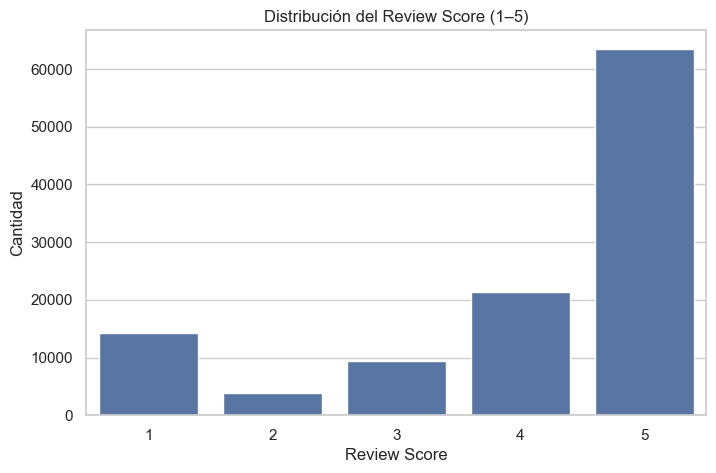


=== TOP 15 CATEGORÍAS CON MAYOR INSATISFACCIÓN ===
     product_category_name  num_bad_reviews
13         cama_mesa_banho             2112
53        moveis_decoracao             1621
43  informatica_acessorios             1461
11            beleza_saude             1321
31           esporte_lazer             1260
71   utilidades_domesticas             1086
65      relogios_presentes              967
69               telefonia              761
39      ferramentas_jardim              696
8               automotivo              643
12              brinquedos              552
9                    bebes              509
61              perfumaria              498
25              cool_stuff              495
54       moveis_escritorio              440


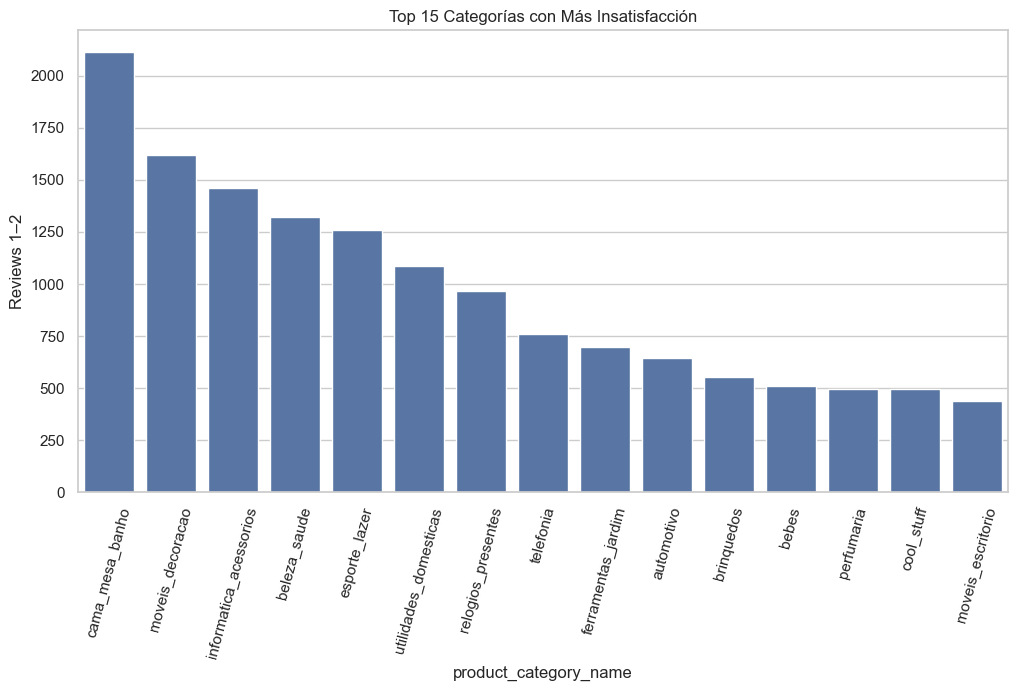


=== TOP 15 CIUDADES DE SELLERS CON MAYOR INSATISFACCIÓN ===
               seller_city  num_bad_reviews
370              sao paulo             4605
158               ibitinga             1607
315         ribeirao preto              478
181        itaquaquecetuba              468
362  sao jose do rio preto              460
342            santo andre              455
321         rio de janeiro              411
228                maringa              404
109               curitiba              378
154              guarulhos              369
39          belo horizonte              307
291             piracicaba              306
66                campinas              269
186                jacarei              190
307           praia grande              182


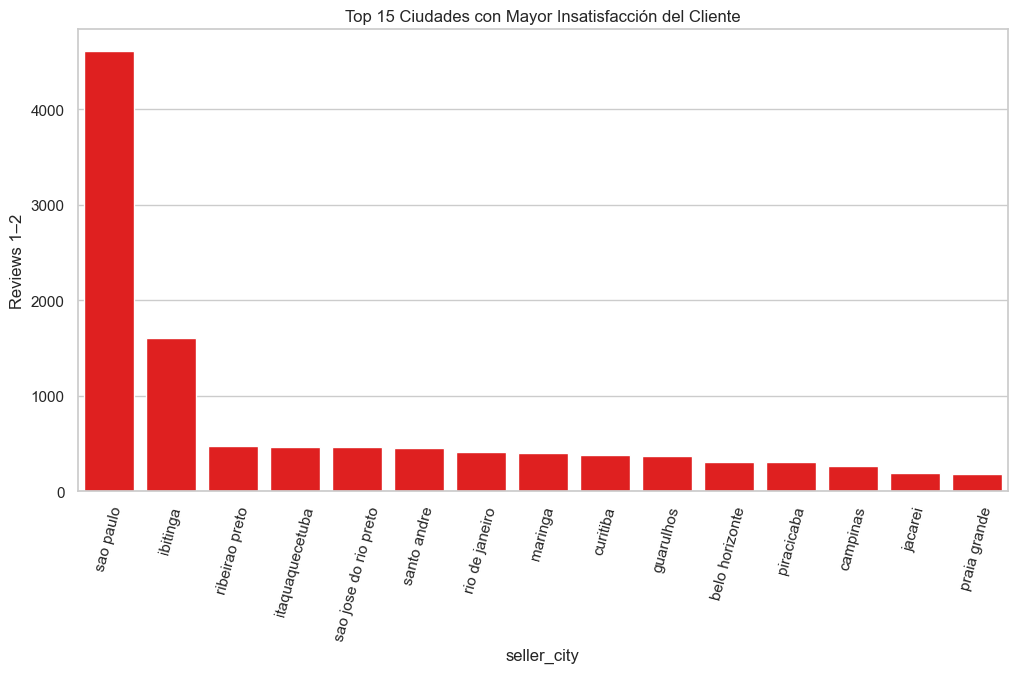

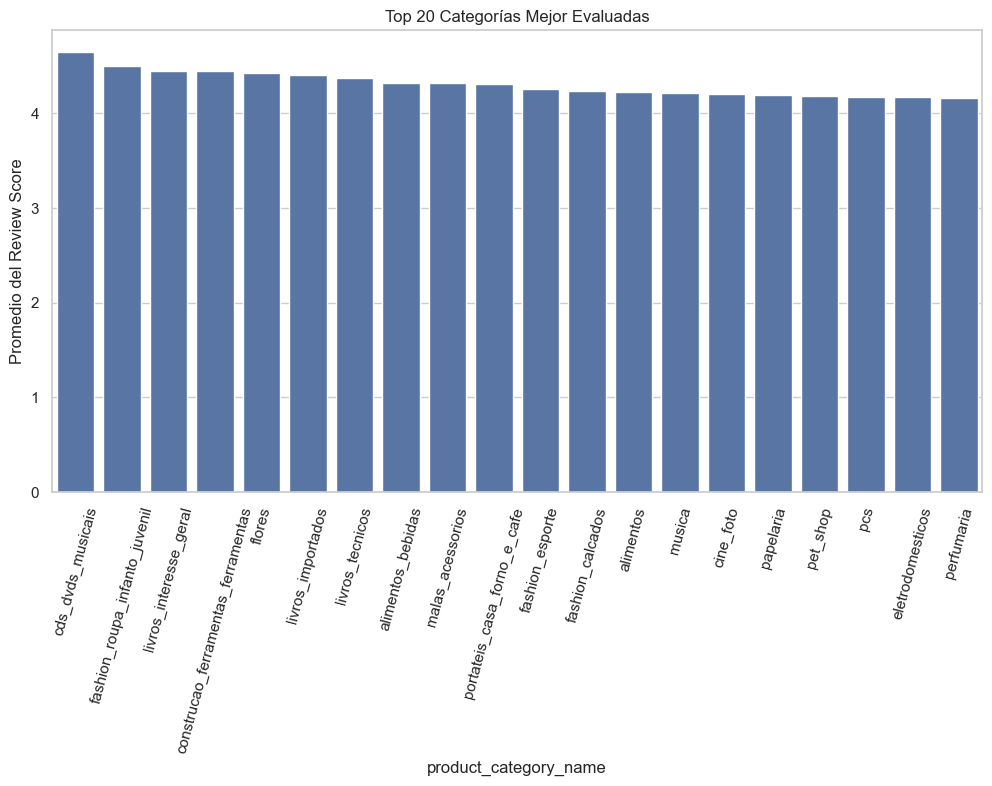

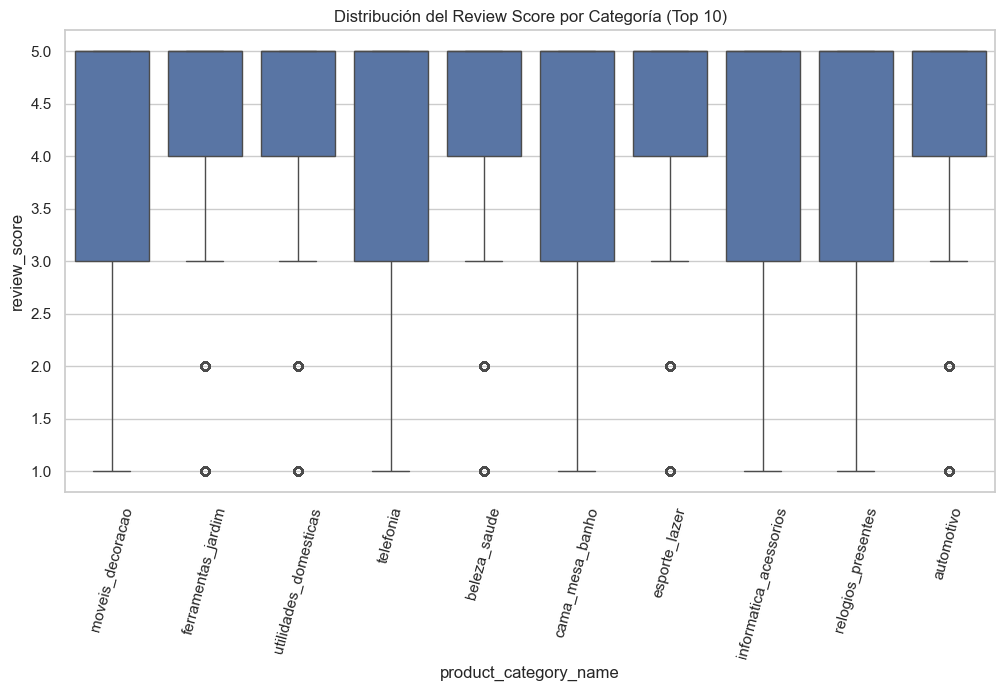

In [16]:
# ============================================
# 1. LIBRERÍAS
# ============================================
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

# ============================================
# 2. CARGAR DATASETS
# ============================================
orders = pd.read_csv("./dataset/olist_order_items_dataset.csv")
reviews = pd.read_csv("./dataset/olist_order_reviews_dataset.csv")
products = pd.read_csv("./dataset/olist_products_dataset.csv")
sellers = pd.read_csv("./dataset/olist_sellers_dataset.csv")

# ============================================
# 3. UNIFICAR TABLAS
# ============================================
df = orders.merge(reviews, on="order_id", how="inner")
df = df.merge(products, on="product_id", how="left")
df = df.merge(sellers, on="seller_id", how="left")

df = df[df["review_score"].notna()]   # Limpiar datos vacíos

# ============================================
# 4. DISTRIBUCIÓN DEL REVIEW SCORE
# ============================================
plt.figure(figsize=(8,5))
sns.countplot(x=df["review_score"])
plt.title("Distribución del Review Score (1–5)")
plt.xlabel("Review Score")
plt.ylabel("Cantidad")
plt.show()

# ============================================
# 5. INSATISFACCIÓN POR PRODUCT CATEGORY
# ============================================
insatis = df[df["review_score"] <= 2]    # Reviews 1–2 = insatisfacción

top_cat = (
    insatis.groupby("product_category_name")
           .size()
           .reset_index(name="num_bad_reviews")
           .sort_values("num_bad_reviews", ascending=False)
           .head(15)
)

print("\n=== TOP 15 CATEGORÍAS CON MAYOR INSATISFACCIÓN ===")
print(top_cat)

plt.figure(figsize=(12,6))
sns.barplot(data=top_cat, x="product_category_name", y="num_bad_reviews")
plt.title("Top 15 Categorías con Más Insatisfacción")
plt.xticks(rotation=75)
plt.ylabel("Reviews 1–2")
plt.show()

# ============================================
# 6. INSATISFACCIÓN POR SELLER CITY
# ============================================
top_city = (
    insatis.groupby("seller_city")
           .size()
           .reset_index(name="num_bad_reviews")
           .sort_values("num_bad_reviews", ascending=False)
           .head(15)
)

print("\n=== TOP 15 CIUDADES DE SELLERS CON MAYOR INSATISFACCIÓN ===")
print(top_city)

plt.figure(figsize=(12,6))
sns.barplot(data=top_city, x="seller_city", y="num_bad_reviews", color="red")
plt.title("Top 15 Ciudades con Mayor Insatisfacción del Cliente")
plt.xticks(rotation=75)
plt.ylabel("Reviews 1–2")
plt.show()

# ============================================
# 7. PROMEDIO DE REVIEW SCORE POR CATEGORÍA
# ============================================
cat_score = (
    df.groupby("product_category_name")["review_score"]
      .mean()
      .reset_index()
      .sort_values("review_score", ascending=False)
)

plt.figure(figsize=(12,6))
sns.barplot(data=cat_score.head(20), x="product_category_name", y="review_score")
plt.title("Top 20 Categorías Mejor Evaluadas")
plt.xticks(rotation=75)
plt.ylabel("Promedio del Review Score")
plt.show()

# ============================================
# 8. BOXPLOT REVIEW SCORE POR CATEGORÍA (TOP 10 MÁS VENDIDOS)
# ============================================
top10_cats = (
    df["product_category_name"]
      .value_counts()
      .head(10)
      .index
)

df_top10 = df[df["product_category_name"].isin(top10_cats)]

plt.figure(figsize=(12,6))
sns.boxplot(data=df_top10, x="product_category_name", y="review_score")
plt.title("Distribución del Review Score por Categoría (Top 10)")
plt.xticks(rotation=75)
plt.show()


In [17]:
import pandas as pd
import numpy as np

# ============================================================
# 1. Cargar datasets
# ============================================================
orders = pd.read_csv("./dataset/olist_orders_dataset.csv")
order_items = pd.read_csv("./dataset/olist_order_items_dataset.csv")
reviews = pd.read_csv("./dataset/olist_order_reviews_dataset.csv")
products = pd.read_csv("./dataset/olist_products_dataset.csv")
sellers = pd.read_csv("./dataset/olist_sellers_dataset.csv")
payments = pd.read_csv("./dataset/olist_order_payments_dataset.csv")

# ============================================================
# 2. Merge maestro
# ============================================================
df = orders.merge(order_items, on="order_id", how="left")
df = df.merge(reviews, on="order_id", how="left")
df = df.merge(products, on="product_id", how="left")
df = df.merge(sellers, on="seller_id", how="left")
df = df.merge(payments, on="order_id", how="left")

# ============================================================
# 3. Limpieza y nuevas variables
# ============================================================
# Fechas
date_cols = ["order_purchase_timestamp","order_approved_at",
             "order_delivered_customer_date","order_estimated_delivery_date"]
for c in date_cols:
    df[c] = pd.to_datetime(df[c])

# Review scores
df["review_score"] = df["review_score"].fillna(df["review_score"].median())
df["is_bad"] = (df["review_score"] <= 2).astype(int)
df["is_good"] = (df["review_score"] >= 4).astype(int)

# Satisfacción y churn
df["satisfaction"] = df["review_score"].apply(lambda x: 0 if x >= 4 else 1)
df["churn_flag"] = df["review_score"].apply(lambda x: 1 if x <= 2 else 0)

# Delivery
df["delivery_time_days"] = (df["order_delivered_customer_date"] - df["order_purchase_timestamp"]).dt.days
df["estimated_delay_days"] = (df["order_delivered_customer_date"] - df["order_estimated_delivery_date"]).dt.days
df["was_late"] = (df["estimated_delay_days"] > 0).astype(int)
df["approval_delay"] = (df["order_approved_at"] - df["order_purchase_timestamp"]).dt.days

# Temporal
df["purchase_month"] = df["order_purchase_timestamp"].dt.month
df["purchase_quarter"] = df["order_purchase_timestamp"].dt.quarter
df["purchase_week"] = df["order_purchase_timestamp"].dt.isocalendar().week
df["purchase_dayofweek"] = df["order_purchase_timestamp"].dt.dayofweek
df["purchase_hour"] = df["order_purchase_timestamp"].dt.hour
df["purchase_bimester"] = ((df["purchase_month"]-1)//2 + 1)
df["purchase_semester"] = ((df["purchase_month"]-1)//6 + 1)

# Texto
df["review_length"] = df["review_comment_message"].fillna("").apply(len)
df["num_exclamations"] = df["review_comment_message"].fillna("").apply(lambda x: x.count('!'))
df["num_question_marks"] = df["review_comment_message"].fillna("").apply(lambda x: x.count('?'))
df["num_words"] = df["review_comment_message"].fillna("").apply(lambda x: len(x.split()))

# ============================================================
# 4. Features por cliente
# ============================================================
customer_features = df.groupby("customer_id").agg(
    cust_total_orders=("order_id","count"),
    cust_total_spent=("price","sum"),
    cust_avg_price=("price","mean"),
    cust_avg_freight=("freight_value","mean"),
    cust_num_products=("product_id","nunique"),
    cust_review_mean=("review_score","mean"),
    cust_review_std=("review_score","std"),
    cust_review_min=("review_score","min"),
    cust_review_max=("review_score","max"),
    cust_num_bad_reviews=("is_bad","sum"),
    cust_num_good_reviews=("is_good","sum"),
    cust_bad_ratio=("is_bad","mean"),
    cust_good_ratio=("is_good","mean"),
    cust_avg_delivery=("delivery_time_days","mean"),
    cust_late_ratio=("was_late","mean"),
    cust_churn=("churn_flag","max"),
    cust_satisfaction=("satisfaction","max"),
    cust_approval_delay_mean=("approval_delay","mean"),
    cust_review_length_mean=("review_length","mean"),
    cust_num_exclamations=("num_exclamations","sum"),
    cust_num_question_marks=("num_question_marks","sum"),
    cust_num_words=("num_words","sum")
).reset_index()

# Recencia y frecuencia
today = pd.Timestamp('2025-11-17')
last_order = df.groupby("customer_id")["order_purchase_timestamp"].max().reset_index()
last_order.rename(columns={"order_purchase_timestamp":"last_order"}, inplace=True)
customer_features = customer_features.merge(last_order, on="customer_id", how="left")
customer_features['recency_days'] = (today - customer_features['last_order']).dt.days
customer_features.drop(columns=["last_order"], inplace=True)

order_dates = df.groupby('customer_id')['order_purchase_timestamp'].apply(lambda x: x.sort_values().diff().dt.days.mean()).reset_index()
order_dates.rename(columns={"order_purchase_timestamp":"avg_days_between_orders"}, inplace=True)
customer_features = customer_features.merge(order_dates, on="customer_id", how="left")

# ============================================================
# 5. Features por producto
# ============================================================
product_features = df.groupby("product_id").agg(
    prod_total_orders=("order_id","count"),
    prod_avg_price=("price","mean"),
    prod_avg_freight=("freight_value","mean"),
    prod_review_mean=("review_score","mean"),
    prod_review_std=("review_score","std"),
    prod_bad_ratio=("is_bad","mean"),
    prod_good_ratio=("is_good","mean"),
    prod_unique_sellers=("seller_id","nunique")
).reset_index()

# ============================================================
# 6. Features por categoría de producto
# ============================================================
cat_features = df.groupby("product_category_name").agg(
    cat_total_orders=("order_id","count"),
    cat_avg_price=("price","mean"),
    cat_avg_freight=("freight_value","mean"),
    cat_review_mean=("review_score","mean"),
    cat_review_std=("review_score","std"),
    cat_bad_ratio=("is_bad","mean"),
    cat_good_ratio=("is_good","mean")
).reset_index()

# ============================================================
# 7. Features por seller
# ============================================================
seller_features = df.groupby("seller_id").agg(
    seller_total_sales=("order_id","count"),
    seller_num_products=("product_id","nunique"),
    seller_avg_price=("price","mean"),
    seller_avg_freight=("freight_value","mean"),
    seller_review_mean=("review_score","mean"),
    seller_review_std=("review_score","std"),
    seller_bad_ratio=("is_bad","mean"),
    seller_good_ratio=("is_good","mean")
).reset_index()

seller_features = seller_features.merge(sellers[["seller_id","seller_city","seller_state"]], on="seller_id", how="left")

# ============================================================
# 8. Features cruzadas: cliente × producto, cliente × seller, cliente × categoría
# ============================================================
# Producto más comprado por cliente
cust_prod = df.groupby(["customer_id","product_id"]).size().reset_index(name="cust_prod_count")
cust_prod = cust_prod.sort_values(['customer_id','cust_prod_count'],ascending=False).drop_duplicates('customer_id')
customer_features = customer_features.merge(cust_prod[['customer_id','product_id','cust_prod_count']], on='customer_id', how='left')

# Seller más frecuente
cust_seller = df.groupby(["customer_id","seller_id"]).size().reset_index(name="cust_seller_count")
cust_seller = cust_seller.sort_values(['customer_id','cust_seller_count'],ascending=False).drop_duplicates('customer_id')
customer_features = customer_features.merge(cust_seller[['customer_id','seller_id','cust_seller_count']], on='customer_id', how='left')

# Categoría más frecuente
cust_cat = df.groupby(["customer_id","product_category_name"]).size().reset_index(name="cust_cat_count")
cust_cat = cust_cat.sort_values(['customer_id','cust_cat_count'],ascending=False).drop_duplicates('customer_id')
customer_features = customer_features.merge(cust_cat[['customer_id','product_category_name','cust_cat_count']], on='customer_id', how='left')

# ============================================================
# 9. One-hot features temporales (mes, bimestre, trimestre, semestre)
# ============================================================
time_cols = ['purchase_month','purchase_bimester','purchase_quarter','purchase_semester','purchase_dayofweek']
for c in time_cols:
    dummies = pd.get_dummies(df.groupby('customer_id')[c].agg(lambda x: x.mode()[0]).reset_index()[c], prefix=c)
    customer_features = pd.concat([customer_features, dummies], axis=1)

# ============================================================
# 10. Features finales
# ============================================================
final_df = customer_features.copy()

# Tipo de variable
feature_types = pd.DataFrame({
    "feature": final_df.columns,
    "type": ["numérica" if np.issubdtype(final_df[col].dtype, np.number) else "categórica"
             for col in final_df.columns]
})

print("Total features generadas:", len(final_df.columns))
print(feature_types.head(150))


KeyboardInterrupt: 

In [ ]:
import pandas as pd
import numpy as np

# ============================================================
# 1. Cargar datasets
# ============================================================
orders = pd.read_csv("./dataset/olist_orders_dataset.csv")
order_items = pd.read_csv("./dataset/olist_order_items_dataset.csv")
reviews = pd.read_csv("./dataset/olist_order_reviews_dataset.csv")
products = pd.read_csv("./dataset/olist_products_dataset.csv")
sellers = pd.read_csv("./dataset/olist_sellers_dataset.csv")
payments = pd.read_csv("./dataset/olist_order_payments_dataset.csv")

# ============================================================
# 2. Merge maestro
# ============================================================
df = orders.merge(order_items, on="order_id", how="left")
df = df.merge(reviews, on="order_id", how="left")
df = df.merge(products, on="product_id", how="left")
df = df.merge(sellers, on="seller_id", how="left")
df = df.merge(payments, on="order_id", how="left")

# ============================================================
# 3. Limpieza y nuevas variables
# ============================================================
date_cols = ["order_purchase_timestamp","order_approved_at",
             "order_delivered_customer_date","order_estimated_delivery_date"]
for c in date_cols:
    df[c] = pd.to_datetime(df[c])

# Review scores
df["review_score"] = df["review_score"].fillna(df["review_score"].median())
df["is_bad"] = (df["review_score"] <= 2).astype(int)
df["is_good"] = (df["review_score"] >= 4).astype(int)

# Satisfacción y churn
df["satisfaction"] = df["review_score"].apply(lambda x: 0 if x >= 4 else 1)
df["churn_flag"] = df["review_score"].apply(lambda x: 1 if x <= 2 else 0)

# Delivery
df["delivery_time_days"] = (df["order_delivered_customer_date"] - df["order_purchase_timestamp"]).dt.days
df["estimated_delay_days"] = (df["order_delivered_customer_date"] - df["order_estimated_delivery_date"]).dt.days
df["was_late"] = (df["estimated_delay_days"] > 0).astype(int)
df["approval_delay"] = (df["order_approved_at"] - df["order_purchase_timestamp"]).dt.days

# Temporal
df["purchase_month"] = df["order_purchase_timestamp"].dt.month
df["purchase_quarter"] = df["order_purchase_timestamp"].dt.quarter
df["purchase_week"] = df["order_purchase_timestamp"].dt.isocalendar().week
df["purchase_dayofweek"] = df["order_purchase_timestamp"].dt.dayofweek
df["purchase_hour"] = df["order_purchase_timestamp"].dt.hour
df["purchase_bimester"] = ((df["purchase_month"]-1)//2 + 1)
df["purchase_semester"] = ((df["purchase_month"]-1)//6 + 1)

# Texto
df["review_length"] = df["review_comment_message"].fillna("").apply(len)
df["num_exclamations"] = df["review_comment_message"].fillna("").apply(lambda x: x.count('!'))
df["num_question_marks"] = df["review_comment_message"].fillna("").apply(lambda x: x.count('?'))
df["num_words"] = df["review_comment_message"].fillna("").apply(lambda x: len(x.split()))

# ============================================================
# 4. Features por cliente (incluyendo review_score)
# ============================================================
customer_features = df.groupby("customer_id").agg(
    cust_total_orders=("order_id","count"),
    cust_total_spent=("price","sum"),
    cust_avg_price=("price","mean"),
    cust_avg_freight=("freight_value","mean"),
    cust_num_products=("product_id","nunique"),
    cust_review_mean=("review_score","mean"),
    cust_review_std=("review_score","std"),
    cust_review_min=("review_score","min"),
    cust_review_max=("review_score","max"),
    cust_review_range=("review_score",lambda x: x.max() - x.min()),
    cust_num_bad_reviews=("is_bad","sum"),
    cust_num_good_reviews=("is_good","sum"),
    cust_bad_ratio=("is_bad","mean"),
    cust_good_ratio=("is_good","mean"),
    cust_avg_delivery=("delivery_time_days","mean"),
    cust_late_ratio=("was_late","mean"),
    cust_churn=("churn_flag","max"),
    cust_satisfaction=("satisfaction","max"),
    cust_approval_delay_mean=("approval_delay","mean"),
    cust_review_length_mean=("review_length","mean"),
    cust_num_exclamations=("num_exclamations","sum"),
    cust_num_question_marks=("num_question_marks","sum"),
    cust_num_words=("num_words","sum")
).reset_index()

# Recencia y frecuencia
today = pd.Timestamp('2025-11-17')
last_order = df.groupby("customer_id")["order_purchase_timestamp"].max().reset_index()
last_order.rename(columns={"order_purchase_timestamp":"last_order"}, inplace=True)
customer_features = customer_features.merge(last_order, on="customer_id", how="left")
customer_features['recency_days'] = (today - customer_features['last_order']).dt.days
customer_features.drop(columns=["last_order"], inplace=True)

order_dates = df.groupby('customer_id')['order_purchase_timestamp'].apply(lambda x: x.sort_values().diff().dt.days.mean()).reset_index()
order_dates.rename(columns={"order_purchase_timestamp":"avg_days_between_orders"}, inplace=True)
customer_features = customer_features.merge(order_dates, on="customer_id", how="left")

# ============================================================
# 5. Features por producto (con review_score)
# ============================================================
product_features = df.groupby("product_id").agg(
    prod_total_orders=("order_id","count"),
    prod_avg_price=("price","mean"),
    prod_avg_freight=("freight_value","mean"),
    prod_review_mean=("review_score","mean"),
    prod_review_std=("review_score","std"),
    prod_review_min=("review_score","min"),
    prod_review_max=("review_score","max"),
    prod_review_range=("review_score",lambda x: x.max() - x.min()),
    prod_bad_ratio=("is_bad","mean"),
    prod_good_ratio=("is_good","mean"),
    prod_unique_sellers=("seller_id","nunique")
).reset_index()

# ============================================================
# 6. Features por categoría de producto (con review_score)
# ============================================================
cat_features = df.groupby("product_category_name").agg(
    cat_total_orders=("order_id","count"),
    cat_avg_price=("price","mean"),
    cat_avg_freight=("freight_value","mean"),
    cat_review_mean=("review_score","mean"),
    cat_review_std=("review_score","std"),
    cat_review_min=("review_score","min"),
    cat_review_max=("review_score","max"),
    cat_review_range=("review_score",lambda x: x.max() - x.min()),
    cat_bad_ratio=("is_bad","mean"),
    cat_good_ratio=("is_good","mean")
).reset_index()

# ============================================================
# 7. Features por seller (con review_score)
# ============================================================
seller_features = df.groupby("seller_id").agg(
    seller_total_sales=("order_id","count"),
    seller_num_products=("product_id","nunique"),
    seller_avg_price=("price","mean"),
    seller_avg_freight=("freight_value","mean"),
    seller_review_mean=("review_score","mean"),
    seller_review_std=("review_score","std"),
    seller_review_min=("review_score","min"),
    seller_review_max=("review_score","max"),
    seller_review_range=("review_score",lambda x: x.max() - x.min()),
    seller_bad_ratio=("is_bad","mean"),
    seller_good_ratio=("is_good","mean")
).reset_index()

seller_features = seller_features.merge(sellers[["seller_id","seller_city","seller_state"]], on="seller_id", how="left")

# ============================================================
# 8. Merge final de features por cliente
# ============================================================
final_df = customer_features.copy()

# Unir features de producto, categoría y seller
final_df = final_df.merge(df[['customer_id','product_id']].drop_duplicates(), on='customer_id', how='left')
final_df = final_df.merge(product_features, on='product_id', how='left')

final_df = final_df.merge(df[['customer_id','product_category_name']].drop_duplicates(), on='customer_id', how='left')
final_df = final_df.merge(cat_features, on='product_category_name', how='left')

final_df = final_df.merge(df[['customer_id','seller_id']].drop_duplicates(), on='customer_id', how='left')
final_df = final_df.merge(seller_features, on='seller_id', how='left')

# ============================================================
# 9. One-hot features temporales
# ============================================================
time_cols = ['purchase_month','purchase_bimester','purchase_quarter','purchase_semester','purchase_dayofweek']
for c in time_cols:
    dummies = pd.get_dummies(df.groupby('customer_id')[c].agg(lambda x: x.mode()[0]).reset_index()[c], prefix=c)
    final_df = pd.concat([final_df, dummies], axis=1)

# ============================================================
# 10. Tipo de variable
# ============================================================
feature_types = pd.DataFrame({
    "feature": final_df.columns,
    "type": ["numérica" if np.issubdtype(final_df[col].dtype, np.number) else "categórica"
             for col in final_df.columns]
})

print("Total features generadas:", len(final_df.columns))
print(feature_types.head(50))


TypeError: Must provide 'func' or tuples of '(column, aggfunc).